In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from time import time
from sklearn.decomposition import PCA
from sklearn.metrics import f1_score, precision_recall_curve, precision_score, recall_score, accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LeakyReLU, Reshape, Flatten, SimpleRNN, ReLU
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from bokeh.plotting import figure, show, output_file, output_notebook
from bokeh.io import export_svgs
import bokeh as bk
output_notebook()
%matplotlib inline

Loading BokehJS ...

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
#datos = pd.read_csv("./drive/My Drive/Colab Notebooks/data/all_counts_9_norm_rpkm_log2_preprocessed.csv", index_col=0)
datos = pd.read_csv("./data/all_counts_9_norm_rpkm_log2_preprocessed.csv", index_col=0)
datos.head()

,BB9,BB10,BB17,BB19,BB20,BB21,BB11,BB12,BB18
gene,,,,,,,,,
aaeA,5.542667,5.876225,5.189101,6.178741,6.258982,5.921482,6.565341,6.308676,6.256590
aaeB,5.627977,5.436188,5.397088,5.493631,5.603751,5.716862,5.840627,6.132819,5.896502
aaeR,5.645506,5.758852,5.107190,5.824890,5.487705,6.033795,5.710782,6.302440,16.270368
aaeX,6.081770,6.043589,6.030808,6.358792,15.682419,6.129392,6.042647,6.134309,15.797839
aas,6.224669,6.297153,6.297008,6.047021,6.038410,6.296795,6.295251,6.598525,6.568365


In [3]:
#obj_rg = open("./drive/My Drive/Colab Notebooks/data/reference_genes.txt")
obj_rg = open("./data/reference_genes.txt")
rg = obj_rg.read().splitlines()
rg.remove("idnT")
print("quantidade de genes de referência:", len(rg))
print(rg)

quantidade de genes de referência: 20
['cysG', 'hcaT', 'rrsA', 'ihfB', 'ssrA', 'gyrA', 'recA', 'rpoB', 'rpoA', 'gyrB', 'rho', 'ftsZ', 'secA', 'rpoC', 'gmk', 'adk', 'rpoD', 'dnaG', 'glnA', 'recF']


In [4]:
X_rg = datos.loc[rg]
X_rg

,BB9,BB10,BB17,BB19,BB20,BB21,BB11,BB12,BB18
gene,,,,,,,,,
cysG,5.903687,5.879490,5.873191,5.735536,6.016590,6.328393,6.315338,6.504277,6.577601
hcaT,5.692781,5.733848,5.686571,5.925712,6.290692,6.131968,6.113390,5.891730,5.822536
rrsA,10.498560,10.775182,11.515848,11.819169,11.745607,11.033925,10.521316,8.685239,10.590185
ihfB,11.625723,11.784312,12.694811,13.119308,13.096534,12.574847,12.140031,10.126885,11.298441
ssrA,12.889916,13.026561,13.839784,14.807551,14.601034,13.858224,14.509441,12.713618,13.816964
gyrA,19.364537,19.544602,10.195372,19.601927,19.576949,18.693722,17.988391,16.700954,17.802523
recA,16.741059,16.808839,17.125494,11.214665,10.997956,10.271486,19.879175,18.190008,19.661178
rpoB,8.974988,19.071784,10.029701,19.552264,19.479836,18.539912,8.439041,16.884159,18.085799
rpoA,12.169900,12.425077,13.123721,12.536993,12.467720,11.604108,11.477677,19.684894,11.166540


In [5]:
class scaler:
    def __init__(self, xmin, xmax):
        """
        minmax scaler from dataframe
        """
        self.xmin = xmin
        self.xmax = xmax
        self.min_data = False
        self.max_data = False
        self.flag = False
        
    def fit(self, X):
        self.min_data = np.min(X).values
        self.max_data = np.max(X).values
        self.flag = True
        
    def transform(self, X):
        assert self.flag, "Erro de treinamento, primeiro tem que treinar o Scaler"
        X_r = X.copy()
        X_r = ((X_r - self.min_data)/(self.max_data - self.min_data))*(self.xmax-self.xmin) + self.xmin
        return X_r
    
    def inverse_transform(self, X):
        assert self.flag, "Erro de treinamento, primeiro tem que treinar o Scaler"
        X_r = X.copy()
        X_r = ((X_r - self.xmin)*(self.max_data - self.min_data)/(self.xmax - self.xmin)) + self.min_data
        return X_r

In [6]:
obj = scaler(-1,1)
obj.fit(X_rg)
X_train = obj.transform(X_rg)
X_train

,BB9,BB10,BB17,BB19,BB20,BB21,BB11,BB12,BB18
gene,,,,,,,,,
cysG,-0.969147,-0.978963,-0.973373,-1.000000,-1.000000,-0.970143,-0.970659,-0.911181,-0.890876
hcaT,-1.000000,-1.000000,-1.000000,-0.972570,-0.959573,-1.000000,-1.000000,-1.000000,-1.000000
rrsA,-0.296977,-0.271812,-0.168266,-0.122535,-0.155035,-0.254901,-0.359582,-0.594943,-0.310966
ihfB,-0.132088,-0.126050,-0.000049,0.064988,0.044212,-0.020681,-0.124403,-0.385905,-0.208607
ssrA,0.052847,0.053385,0.163319,0.308490,0.266109,0.174393,0.219843,-0.010831,0.155377
gyrA,1.000000,0.994874,-0.356674,1.000000,1.000000,0.909390,0.725292,0.567331,0.731382
recA,0.616219,0.599711,0.632131,-0.209725,-0.265305,-0.370792,1.000000,0.783242,1.000000
rpoB,-0.519856,0.926579,-0.380312,0.992837,0.985677,0.886011,-0.662111,0.593895,0.772322
rpoA,-0.052482,-0.033495,0.061149,-0.019001,-0.048531,-0.168233,-0.220635,1.000000,-0.227669


In [7]:
X_cand = datos.drop(rg)
X_cand.shape

(4168, 9)

In [8]:
X_cand = obj.transform(X_cand)
X_cand.shape

(4168, 9)

In [9]:
class Generator():
    def __init__(self, noise_input, out_dim, optimizerG):
        self.noise_input = noise_input
        self.out_dim = out_dim
        self.optimizerG = optimizerG
        
    def generator(self):
        """
        noise_input: vector con los datos de la distribuición inicial
        out_dim: dimension de la salida esperada, por ejemplo si es una imagen
                 en escala de gris, sería out_dim: (32,32,1)
        Retorna el modelo Generador
        """
        model = Sequential()
        model.add(Dense(50, input_shape=(self.noise_input,)))
        model.add(Dense(150))
        model.add(Dropout(.15))
        model.add(Dense(np.prod(self.out_dim), activation="tanh"))
        model.add(Reshape(self.out_dim))
        return model
    
    def compileG(self):
        Gr = self.generator()
        Gr.compile(loss="binary_crossentropy", optimizer= self.optimizerG)
        return Gr

In [10]:
class Discriminator():
    
    def __init__(self, input_dim, optimizerD):
        self.input_dim = input_dim
        self.optimizerD = optimizerD
    
    def discriminator(self):
        """
        input_dim: dimension de los datos de entrada,
                   por ejemplo si es una imagen en escala de gris,
                   sería input_dim: (32,32,1)
        """
        model = Sequential()
        model.add(Dense(32, input_shape=self.input_dim))
        model.add(LeakyReLU(alpha=.2)) #función rectificadora
        model.add(Dense(32))
        #model.add(LeakyReLU(alpha=.1)) #función rectificadora
        #activación sigmoid ya que se precisa establecer si es 0 ó 1.
        model.add(Dense(1, activation='sigmoid'))
        return model
    
    def compileD(self):
        Dr = self.discriminator()
        Dr.compile(loss="binary_crossentropy", optimizer=optimizerD, metrics=["accuracy"])
        return Dr

In [11]:
def Gan(generator, discriminator):
    """
    recibe como parámetros de entrada las redes
    generador y discriminador
    """
    model = Sequential()
    model.add(generator)
    discriminator.trainable = False #no se actualizan los pesos
    model.add(discriminator)
    return model

In [12]:
def get_batches(X_train, batch_size):
    """
    X_train: dataset para o treino
    epochs: quantidade de epocas para o treino do gradiente
    batch: tamanho to batch pra o treino de cada epochs
    """
    batches = []
    num_bat = int(np.ceil(X_train.shape[0]/batch_size))
    lim_i = 0
    lim_s = batch_size
    for i in range(num_bat):
        if lim_s > X_train.shape[0]:
            lim_s = X_train.shape[0]
        batches.append(X_train[lim_i:lim_s])
        lim_i += batch_size
        lim_s += batch_size
    return batches

In [40]:
#treinamento da GAN
def train(X_train, epochs, batch_size, G, D, gan, noise_input, verbose=True):
    """
    function to train the GAN architecture
    return:
    g_loss: loss of the generator network
    d_loss: loss of the discriminator network
    precision: precision of the discriminator network
    recall : recall score of the discriminator network
    kl_d: kullback-leibler divergence of the GAN
    """
    g_loss = []
    d_loss = []
    precision = []
    recall = []
    kl_d = []
    for epoch in range(epochs):
        batches = get_batches(X_train, batch_size)
        count_b = 0
        t_i = time()
        d_bacth_loss = []
        g_bacth_loss = []
        for batch in batches:
            gen_noise = np.random.normal(0, 1, (np.int64(batch.shape[0]), noise_input))
            #gerando as imagens fake
            syntetic_data = G.predict(gen_noise)
            #criação do array de treinamento
            x_combined_batch = np.concatenate((batch, syntetic_data))
            y_combined_batch = np.concatenate((np.ones((batch.shape[0], 1)),
                                               np.zeros((batch.shape[0], 1))))
            #misturar os dados
            #x_combined_batch, y_combined_batch = shuffle(x_combined_batch, y_combined_batch)
            #treino do discriminador
            d_bacth_loss.append(D.train_on_batch(x_combined_batch, y_combined_batch)[0])
            # train generator
            noise = np.random.normal(0, 1, (2*batch.shape[0], noise_input))
            y_mislabled = np.ones((2*batch.shape[0], 1))
            g_bacth_loss.append(gan.train_on_batch(noise, y_mislabled))
        
        #precision
        X_sint = G.predict(np.random.normal(0, 1, (X_train.shape[0], noise_input)))
        X_comb = np.concatenate((X_train, X_sint))
        y_comb = np.concatenate((np.ones((X_train.shape[0],1)), np.zeros((X_sint.shape[0],1))))
        y_predict = D.predict_classes(X_comb)
        y_proba = D.predict_proba(X_comb)
        #kl_d.append(np.mean((1-y_proba)/y_proba))
        kl_d.append(np.mean(y_proba*np.log(y_proba/(1-y_proba))))
        #f1_lag = f1_score(y_test, y_predict)
        precision.append(precision_score(y_comb, y_predict))
        recall.append(recall_score(y_comb, y_predict))
        #fscore.append(f1_lag)
        t_f = time()
        t = t_f - t_i
        t_i = time()

        d_loss.append(d_bacth_loss[-1])
        g_loss.append(g_bacth_loss[-1])
        if verbose:
            print ('epoch:[%d/%d] [Discriminator::d_loss: %f],[Generator::loss: %f], %f[sec]'
                   % (epoch+1, epochs, d_loss[-1], g_loss[-1], t))

    return g_loss, d_loss, precision, recall, kl_d

In [14]:
noise_input = 50
ep = 1700
#Gerador
optimizerG = SGD(lr=0.00015, momentum=0.92, decay=0.00015/ep)
#optimizerG = SGD(lr=0.00011, momentum=0.92)
obj_G = Generator(noise_input, (X_train.shape[1],), optimizerG)
print("Dimension del ruido de entrada: ",noise_input)
G = obj_G.compileG()
# Discriminador
optimizerD = SGD(lr=0.001, momentum=0.9, decay=0.001/ep)
#optimizerD = SGD(lr=0.001, momentum=0.9)
objD = Discriminator((X_train.shape[1],), optimizerD)
D = objD.compileD()
gan = Gan(G,D)
gan.compile(loss='binary_crossentropy', optimizer=optimizerG)
gan.summary()

Dimension del ruido de entrada:  50
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 9)                 11559     
_________________________________________________________________
sequential_1 (Sequential)    (None, 1)                 1409      
Total params: 12,968
Trainable params: 11,559
Non-trainable params: 1,409
_________________________________________________________________


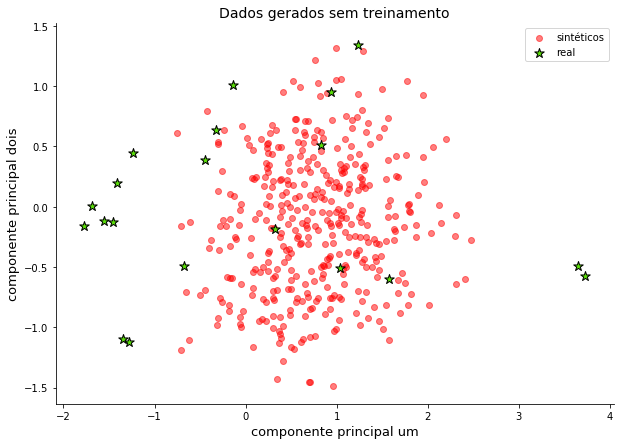

In [15]:
pca_real = PCA(n_components=2)
X_train_pca = pca_real.fit_transform(X_train)

noise = np.random.normal(0, 1, size=(X_train.shape[0]*20, noise_input))
fig1 = plt.figure(figsize=(10,7))
ax1 = fig1.add_subplot()
ax1.spines["top"].set_visible(False)
ax1.spines["right"].set_visible(False)
plt.title("Dados gerados sem treinamento", fontsize=14)
plt.xlabel("componente principal um", fontsize=13)
plt.ylabel("componente principal dois", fontsize=13)
x_noise = G.predict(noise)
X_sint_pca = pca_real.transform(x_noise)
plt.scatter(X_sint_pca[:,0], X_sint_pca[:,1], color="red", label="sintéticos", alpha=.5)
plt.scatter(X_train_pca[:,0], X_train_pca[:,1], color="#5ADE09", label="real", alpha=1,
            marker="*", edgecolors="black", s=100)
plt.legend();

In [0]:
g_loss, d_loss, precision, recall, kld = train(X_train, epochs=ep, batch_size=X_train.shape[0], G=G, D=D,
                                          gan=gan, noise_input=noise_input)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
Instructions for updating:
Please use `model.predict()` instead.
epoch:[1/1700] [Discriminator::d_loss: 0.743062],[Generator::loss: 0.666070], 1.022740[sec]
epoch:[2/1700] [Discriminator::d_loss: 0.729001],[Generator::loss: 0.689769], 0.265762[sec]
epoch:[3/1700] [Discriminator::d_loss: 0.734806],[Generator::loss: 0.681545], 0.148529[sec]
epoch:[4/1700] [Discriminator::d_loss: 0.759997],[Generator::loss: 0.692694], 0.136592[sec]
epoch:[5/1700] [Discriminator::d_loss: 0.749624],[Generator::loss: 0.676840], 0.121271[sec]
epoch:[6/1700] [Discriminator::d_loss: 0.720705],[Generator::loss: 0.709272], 0.122151[sec]
epoch:[7/1700] [Discriminator::d_loss: 0.742224],

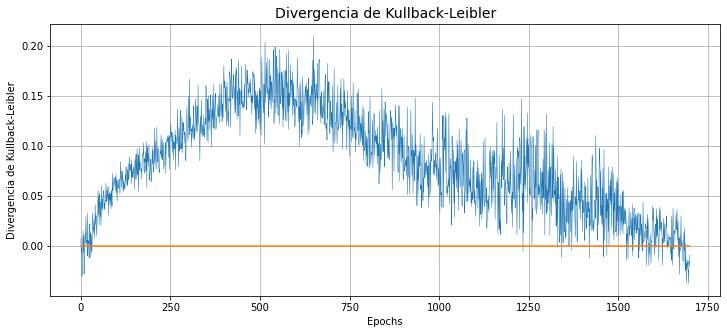

In [0]:
plt.figure(figsize=(12,5))
plt.title("Divergencia de Kullback-Leibler", fontsize=14)
plt.plot(range(len(kld)), kld, linewidth=.5)
plt.plot(range(len(kld)), np.zeros(len(kld)))
plt.grid()
plt.xlabel("Epochs");
plt.ylabel("Divergencia de Kullback-Leibler");

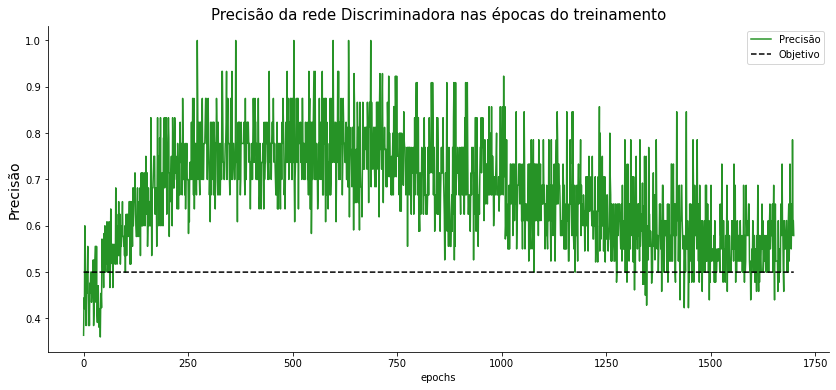

In [0]:
fig = plt.figure(figsize=(14,6))
ax1 = fig.add_subplot()
ax1.spines["right"].set_visible(False)
ax1.spines["top"].set_visible(False)
plt.title("Precisão da rede Discriminadora nas épocas do treinamento", fontsize=15)
plt.xlabel("epochs")
plt.ylabel("Precisão", fontsize=14)
plt.plot(range(len(precision)), precision, color="green", alpha=.85, label="Precisão");
plt.plot(range(len(precision)),np.ones(len(precision))*.5, color="black", ls="--", label="Objetivo");
plt.legend();

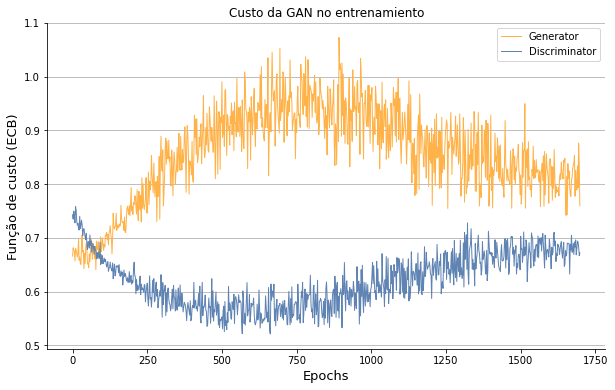

In [0]:
fig = plt.figure(figsize=(10,6))
ax1 = fig.add_subplot()
ax1.spines["top"].set_visible(False)
ax1.spines["right"].set_visible(False)
rr = range(0,len(precision), 2)
short_precision = [precision[i] for i in rr]
short_g_loss = [g_loss[i] for i in rr]
short_d_loss = [d_loss[i] for i in rr]
#plt.title("Loss da GAN nas épocas do treinamento", fontsize=15)
plt.title("Custo da GAN no entrenamiento")
plt.plot(rr, short_g_loss, label="Generator", color="#FFB248", linewidth=1)
plt.plot(rr, short_d_loss, label="Discriminator", color="#5F84B4", linewidth=1)
plt.xlabel("Epochs", fontsize=13)
plt.ylabel("Função de custo (ECB)", fontsize=13)
plt.grid(axis="y")
plt.legend();

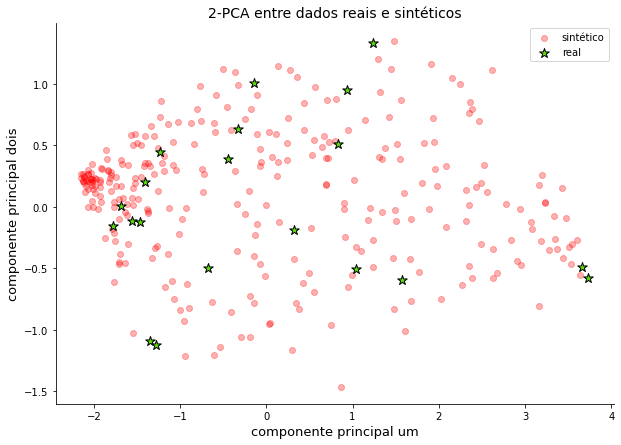

In [0]:
X_sint = G.predict(np.random.normal(0, 1, (300, noise_input)))
X_nov = np.concatenate((X_train[:14], X_sint))

fig2 = plt.figure(figsize=(10,7))
ax2 = fig2.add_subplot()
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)

X_sint_pca = pca_real.transform(X_sint)

plt.title("2-PCA entre dados reais e sintéticos", fontsize=14)
plt.xlabel("componente principal um", fontsize=13)
plt.ylabel("componente principal dois", fontsize=13)
plt.scatter(X_sint_pca[:,0], X_sint_pca[:,1], color="red", label="sintético", alpha=0.3)
plt.scatter(X_train_pca[:,0], X_train_pca[:,1], color="#5ADE09", label="real", alpha=1,
            marker="*", edgecolors="black", s=100)
plt.legend();

In [0]:
min_pre = np.inf
dict_weights = {}
l_dist = []
for i in range(100):
    t_i = time()
    G = obj_G.compileG()
    D = objD.compileD()
    gan = Gan(G,D)
    gan.compile(loss='binary_crossentropy', optimizer=optimizerG)
    g_loss, d_loss, precision, recall, _ = train(X_train, epochs=ep, batch_size=X_train.shape[0], G=G, D=D,
                                          gan=gan, noise_input=noise_input, verbose=False)
    l_pre = []
    for k in range(30):
        X_gen = G.predict(np.random.normal(0, 1, (300, noise_input)))
        #y_proba = D.predict_proba(X_gen)
        y_predict = D.predict_classes(X_gen)
        d = []
        for g in range(X_train.shape[0]):
            #print(np.mean(abs(X_train.iloc[g,:].values-X_gen)))
            #print(abs(1-np.mean((1-y_proba)/y_proba)))
            d.append(np.mean(abs(X_train.iloc[g,:].values-X_gen)))
        l_pre.append(np.mean(np.array(d))+ abs(0.5 - np.mean(y_predict)))

    w_f = gan.get_weights().copy()
    l_dist.append(np.mean(np.array(l_pre)))
    dict_weights[np.mean(np.array(l_pre))] = [i, l_dist[-1], w_f]
    if l_dist[-1] < min_pre:
        min_pre = l_dist[-1]
        w_best = w_f
    t_f = time()
    print("iteração[",i,"] : erro:",l_dist[i],"tempo:", np.round(t_f-t_i,4), "[s]")

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
Instructions for updating:
Please use `model.predict()` instead.
iteração[ 0 ] : erro: 0.9063484896346964 tempo: 198.161 [s]
iteração[ 1 ] : erro: 1.035125284086244 tempo: 202.4993 [s]
iteração[ 2 ] : erro: 0.8085457767552231 tempo: 203.1351 [s]
iteração[ 3 ] : erro: 0.8818297242657106 tempo: 202.8032 [s]
iteração[ 4 ] : erro: 0.8188971081847265 tempo: 208.6005 [s]
iteração[ 5 ] : erro: 0.8167858394499122 tempo: 213.0408 [s]
iteração[ 6 ] : erro: 0.9456828486764717 tempo: 209.8611 [s]
iteração[ 7 ] : erro: 0.8117919935756175 tempo: 208.4451 [s]
iteração[ 8 ] : erro: 0.7750159500487882 tempo: 208.8164 [s]
iteração[ 9 ] : erro: 0.7785488805682073 tempo: 215.74

In [0]:
np.save("./drive/My Drive/Colab Notebooks/data/dictionary_weights", dict_weights)

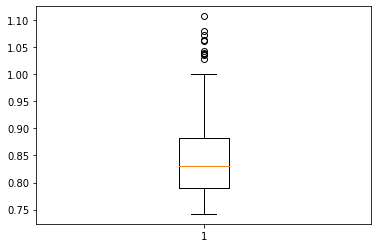

In [0]:
plt.boxplot(l_dist);

In [0]:
dict_weights[0.7723649766331931]

[0, [array([[-0.0355559 ,  0.02731352,  0.02486728, ...,  0.17094366,
          -0.21465062, -0.19510424],
         [ 0.19870575, -0.19854163,  0.00268583, ..., -0.20457327,
           0.09547026, -0.1790467 ],
         [ 0.24036534,  0.16082735,  0.24055083, ...,  0.19479771,
          -0.15399212, -0.21110648],
         ...,
         [-0.20341508,  0.10222159, -0.01730911, ..., -0.17522171,
          -0.20599656,  0.02298634],
         [ 0.20842777,  0.23642649, -0.20786823, ...,  0.02198412,
          -0.19477499, -0.01467268],
         [ 0.13880949, -0.22207598,  0.17832424, ...,  0.03953595,
           0.18898539,  0.14337201]], dtype=float32),
  array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        dtype=float32),
  array([[ 0.09426019,  0.02184075, -0.09427793, ...,  0.06149998,
           0.01516236, 

## Results and plots

In [20]:
dictionary_results = np.load("./data/dictionary_weights.npy", allow_pickle=True).item()

In [67]:
best_s = np.inf
similarity = []
for key in dictionary_results.keys():
    similarity.append(dictionary_results[key][1])
    if dictionary_results[key][1] <= best_s:
        best_s = dictionary_results[key][1]
        best_init_weights = dictionary_results[key][2]

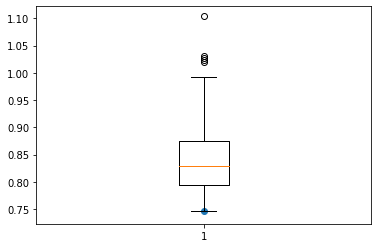

In [68]:
similarity = np.array(similarity)
plt.boxplot(similarity);
plt.scatter(1, min(similarity));

In [69]:
best_s

0.746382147985137

In [70]:
def boxplot_params(x):
    """
    This function retunrs necessary parameters to plot
    a boxplot with bokeh
    """
    q25 = np.quantile(x, .25, interpolation="midpoint")
    q50 = np.quantile(x, .5, interpolation="midpoint")
    q75 = np.quantile(x, .75, interpolation="midpoint")
    IQR = q75 - q25
    lower = q25 - 1.5*IQR
    if lower < min(x): lower = min(x)
    upper = q75 + 1.5*IQR
    outliers = x[[x<lower]and[x>upper]]

    return lower, q25, q50, q75, upper, outliers

In [71]:
lower, q25, q50, q75, upper, outliers = boxplot_params(similarity)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  del sys.path[0]


In [72]:
p = figure(tools="", toolbar_location=None, width=220, height= 250, x_range=[0,2])

p.segment(1, lower, 1, q25, line_color="black")
p.segment(1, upper, 1, q75, line_color="black")
p.rect(1, lower, width=.3, height=.0005, line_color="black")
p.rect(1, upper, width=.3, height=.0005, line_color="black")
p.vbar(1, 0.7, q75, q50, fill_color="#E08E79", line_color="black")
p.vbar(1, 0.7, q50, q25, fill_color="#3B8686", line_color="black")
p.circle(1, outliers, size=7, color="#F38630", fill_alpha=0.6, legend_label="Piores pesos")
#best_case
p.circle(1, min(similarity), size=7, color="green", fill_alpha=0.6, legend_label="Melhor peso")
p.xgrid.grid_line_color = None
p.yaxis.axis_label= "Similaridade (S)"
#p.xaxis.visible = False
p.xaxis.ticker = [1]
#p.yaxis.ticker = [np.round(lower,2), np.round(q25,2), np.round(q50, 2), np.round(q75,2), np.round(upper,2), ]
#p.yaxis.bounds = (np.round(lower,2), np.round(upper,2))
#p.xaxis.axis_line_color = "red"
p.output_backend = "svg"
export_svgs(p, "./images/boxplot_similarity.svg")
show(p)

MaxRetryError: HTTPConnectionPool(host='127.0.0.1', port=53935): Max retries exceeded with url: /wd/hub/session/3f390b20-947c-11ea-9cd9-fb2420601456/url (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7f5e14fa9b38>: Failed to establish a new connection: [Errno 111] Connection refused',))

### Training the GAN architecture with the best initial weights

In [76]:
noise_input = 50
ep = 1700
#Gerador
optimizerG = SGD(lr=0.00015, momentum=0.92, decay=0.00015/ep)
#optimizerG = SGD(lr=0.00011, momentum=0.92)
obj_G = Generator(noise_input, (X_train.shape[1],), optimizerG)
print("Dimension del ruido de entrada: ",noise_input)
G = obj_G.compileG()
# Discriminador
optimizerD = SGD(lr=0.001, momentum=0.9, decay=0.001/ep)
#optimizerD = SGD(lr=0.001, momentum=0.9)
objD = Discriminator((X_train.shape[1],), optimizerD)
D = objD.compileD()
gan = Gan(G,D)
gan.compile(loss='binary_crossentropy', optimizer=optimizerG)
gan.set_weights(best_init_weights)
gan.summary()

Dimension del ruido de entrada:  50
Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_30 (Sequential)   (None, 9)                 11559     
_________________________________________________________________
sequential_31 (Sequential)   (None, 1)                 1409      
Total params: 12,968
Trainable params: 11,559
Non-trainable params: 1,409
_________________________________________________________________


In [74]:
g_loss, d_loss, d_precision, d_recall, kl_d = train(X_train, epochs=ep, batch_size=X_train.shape[0],
                                                    G=G, D=D, gan=gan, noise_input=noise_input)

epoch:[1/1700] [Discriminator::d_loss: 0.631324],[Generator::loss: 0.771151], 0.643322[sec]
epoch:[2/1700] [Discriminator::d_loss: 0.630919],[Generator::loss: 0.721637], 0.086788[sec]
epoch:[3/1700] [Discriminator::d_loss: 0.638532],[Generator::loss: 0.747204], 0.090913[sec]
epoch:[4/1700] [Discriminator::d_loss: 0.669013],[Generator::loss: 0.743852], 0.094975[sec]
epoch:[5/1700] [Discriminator::d_loss: 0.639323],[Generator::loss: 0.725077], 0.090989[sec]
epoch:[6/1700] [Discriminator::d_loss: 0.635692],[Generator::loss: 0.766274], 0.093604[sec]
epoch:[7/1700] [Discriminator::d_loss: 0.660421],[Generator::loss: 0.767521], 0.093947[sec]
epoch:[8/1700] [Discriminator::d_loss: 0.672655],[Generator::loss: 0.764290], 0.101519[sec]
epoch:[9/1700] [Discriminator::d_loss: 0.678135],[Generator::loss: 0.797200], 0.091635[sec]
epoch:[10/1700] [Discriminator::d_loss: 0.642065],[Generator::loss: 0.735488], 0.104536[sec]
epoch:[11/1700] [Discriminator::d_loss: 0.655415],[Generator::loss: 0.736807], 

epoch:[91/1700] [Discriminator::d_loss: 0.660560],[Generator::loss: 0.788362], 0.099402[sec]
epoch:[92/1700] [Discriminator::d_loss: 0.634358],[Generator::loss: 0.758200], 0.086549[sec]
epoch:[93/1700] [Discriminator::d_loss: 0.622767],[Generator::loss: 0.766864], 0.091233[sec]
epoch:[94/1700] [Discriminator::d_loss: 0.616623],[Generator::loss: 0.751624], 0.093829[sec]
epoch:[95/1700] [Discriminator::d_loss: 0.619167],[Generator::loss: 0.735523], 0.091197[sec]
epoch:[96/1700] [Discriminator::d_loss: 0.667185],[Generator::loss: 0.792200], 0.090610[sec]
epoch:[97/1700] [Discriminator::d_loss: 0.617515],[Generator::loss: 0.792348], 0.093413[sec]
epoch:[98/1700] [Discriminator::d_loss: 0.618220],[Generator::loss: 0.771721], 0.101946[sec]
epoch:[99/1700] [Discriminator::d_loss: 0.599056],[Generator::loss: 0.785216], 0.107141[sec]
epoch:[100/1700] [Discriminator::d_loss: 0.629959],[Generator::loss: 0.778166], 0.115086[sec]
epoch:[101/1700] [Discriminator::d_loss: 0.603314],[Generator::loss: 

epoch:[181/1700] [Discriminator::d_loss: 0.627175],[Generator::loss: 0.743671], 0.101128[sec]
epoch:[182/1700] [Discriminator::d_loss: 0.613703],[Generator::loss: 0.779193], 0.087051[sec]
epoch:[183/1700] [Discriminator::d_loss: 0.627722],[Generator::loss: 0.789632], 0.088477[sec]
epoch:[184/1700] [Discriminator::d_loss: 0.597797],[Generator::loss: 0.777628], 0.120831[sec]
epoch:[185/1700] [Discriminator::d_loss: 0.627172],[Generator::loss: 0.765527], 0.147889[sec]
epoch:[186/1700] [Discriminator::d_loss: 0.640008],[Generator::loss: 0.780986], 0.114005[sec]
epoch:[187/1700] [Discriminator::d_loss: 0.604594],[Generator::loss: 0.836113], 0.095716[sec]
epoch:[188/1700] [Discriminator::d_loss: 0.621775],[Generator::loss: 0.763413], 0.095205[sec]
epoch:[189/1700] [Discriminator::d_loss: 0.619368],[Generator::loss: 0.808501], 0.110794[sec]
epoch:[190/1700] [Discriminator::d_loss: 0.641555],[Generator::loss: 0.709637], 0.100569[sec]
epoch:[191/1700] [Discriminator::d_loss: 0.627436],[Generato

epoch:[271/1700] [Discriminator::d_loss: 0.638971],[Generator::loss: 0.768118], 0.091383[sec]
epoch:[272/1700] [Discriminator::d_loss: 0.634745],[Generator::loss: 0.793127], 0.092535[sec]
epoch:[273/1700] [Discriminator::d_loss: 0.630912],[Generator::loss: 0.781608], 0.089527[sec]
epoch:[274/1700] [Discriminator::d_loss: 0.610541],[Generator::loss: 0.767294], 0.093948[sec]
epoch:[275/1700] [Discriminator::d_loss: 0.615222],[Generator::loss: 0.820425], 0.092935[sec]
epoch:[276/1700] [Discriminator::d_loss: 0.617183],[Generator::loss: 0.808867], 0.086349[sec]
epoch:[277/1700] [Discriminator::d_loss: 0.677653],[Generator::loss: 0.773479], 0.100604[sec]
epoch:[278/1700] [Discriminator::d_loss: 0.625842],[Generator::loss: 0.793441], 0.087279[sec]
epoch:[279/1700] [Discriminator::d_loss: 0.603375],[Generator::loss: 0.949302], 0.091131[sec]
epoch:[280/1700] [Discriminator::d_loss: 0.614919],[Generator::loss: 0.815929], 0.092065[sec]
epoch:[281/1700] [Discriminator::d_loss: 0.599485],[Generato

epoch:[360/1700] [Discriminator::d_loss: 0.613959],[Generator::loss: 0.857159], 0.115831[sec]
epoch:[361/1700] [Discriminator::d_loss: 0.624478],[Generator::loss: 0.827615], 0.102380[sec]
epoch:[362/1700] [Discriminator::d_loss: 0.603863],[Generator::loss: 0.809700], 0.091202[sec]
epoch:[363/1700] [Discriminator::d_loss: 0.607817],[Generator::loss: 0.805750], 0.100301[sec]
epoch:[364/1700] [Discriminator::d_loss: 0.609942],[Generator::loss: 0.864173], 0.093265[sec]
epoch:[365/1700] [Discriminator::d_loss: 0.616377],[Generator::loss: 0.818713], 0.093876[sec]
epoch:[366/1700] [Discriminator::d_loss: 0.623698],[Generator::loss: 0.836248], 0.090952[sec]
epoch:[367/1700] [Discriminator::d_loss: 0.619009],[Generator::loss: 0.771424], 0.091249[sec]
epoch:[368/1700] [Discriminator::d_loss: 0.596899],[Generator::loss: 0.827771], 0.087106[sec]
epoch:[369/1700] [Discriminator::d_loss: 0.599447],[Generator::loss: 0.824644], 0.093475[sec]
epoch:[370/1700] [Discriminator::d_loss: 0.619566],[Generato

epoch:[450/1700] [Discriminator::d_loss: 0.601142],[Generator::loss: 0.783887], 0.092957[sec]
epoch:[451/1700] [Discriminator::d_loss: 0.651136],[Generator::loss: 0.872546], 0.092546[sec]
epoch:[452/1700] [Discriminator::d_loss: 0.595497],[Generator::loss: 0.873190], 0.086452[sec]
epoch:[453/1700] [Discriminator::d_loss: 0.604218],[Generator::loss: 0.829504], 0.096289[sec]
epoch:[454/1700] [Discriminator::d_loss: 0.582850],[Generator::loss: 0.798117], 0.088718[sec]
epoch:[455/1700] [Discriminator::d_loss: 0.657874],[Generator::loss: 0.818491], 0.085967[sec]
epoch:[456/1700] [Discriminator::d_loss: 0.640178],[Generator::loss: 0.837740], 0.101424[sec]
epoch:[457/1700] [Discriminator::d_loss: 0.631675],[Generator::loss: 0.789107], 0.087469[sec]
epoch:[458/1700] [Discriminator::d_loss: 0.623083],[Generator::loss: 0.821098], 0.091943[sec]
epoch:[459/1700] [Discriminator::d_loss: 0.621478],[Generator::loss: 0.832472], 0.092058[sec]
epoch:[460/1700] [Discriminator::d_loss: 0.615348],[Generato

epoch:[540/1700] [Discriminator::d_loss: 0.600222],[Generator::loss: 0.797018], 0.093941[sec]
epoch:[541/1700] [Discriminator::d_loss: 0.593777],[Generator::loss: 0.855607], 0.087303[sec]
epoch:[542/1700] [Discriminator::d_loss: 0.612926],[Generator::loss: 0.796289], 0.091577[sec]
epoch:[543/1700] [Discriminator::d_loss: 0.648879],[Generator::loss: 0.823215], 0.095649[sec]
epoch:[544/1700] [Discriminator::d_loss: 0.604477],[Generator::loss: 0.853061], 0.090969[sec]
epoch:[545/1700] [Discriminator::d_loss: 0.587386],[Generator::loss: 0.814805], 0.086474[sec]
epoch:[546/1700] [Discriminator::d_loss: 0.628284],[Generator::loss: 0.886763], 0.100384[sec]
epoch:[547/1700] [Discriminator::d_loss: 0.589577],[Generator::loss: 0.888780], 0.092586[sec]
epoch:[548/1700] [Discriminator::d_loss: 0.594344],[Generator::loss: 0.785712], 0.087033[sec]
epoch:[549/1700] [Discriminator::d_loss: 0.603813],[Generator::loss: 0.864308], 0.096355[sec]
epoch:[550/1700] [Discriminator::d_loss: 0.617216],[Generato

epoch:[628/1700] [Discriminator::d_loss: 0.618233],[Generator::loss: 0.815511], 0.096893[sec]
epoch:[629/1700] [Discriminator::d_loss: 0.597230],[Generator::loss: 0.862147], 0.088976[sec]
epoch:[630/1700] [Discriminator::d_loss: 0.578632],[Generator::loss: 0.836859], 0.092031[sec]
epoch:[631/1700] [Discriminator::d_loss: 0.605324],[Generator::loss: 0.837670], 0.096512[sec]
epoch:[632/1700] [Discriminator::d_loss: 0.621761],[Generator::loss: 0.857293], 0.096217[sec]
epoch:[633/1700] [Discriminator::d_loss: 0.621541],[Generator::loss: 0.863734], 0.096010[sec]
epoch:[634/1700] [Discriminator::d_loss: 0.602074],[Generator::loss: 0.852971], 0.119881[sec]
epoch:[635/1700] [Discriminator::d_loss: 0.618831],[Generator::loss: 0.859850], 0.127891[sec]
epoch:[636/1700] [Discriminator::d_loss: 0.634541],[Generator::loss: 0.856798], 0.091137[sec]
epoch:[637/1700] [Discriminator::d_loss: 0.623003],[Generator::loss: 0.837116], 0.094382[sec]
epoch:[638/1700] [Discriminator::d_loss: 0.632688],[Generato

epoch:[716/1700] [Discriminator::d_loss: 0.570435],[Generator::loss: 0.782825], 0.102262[sec]
epoch:[717/1700] [Discriminator::d_loss: 0.628298],[Generator::loss: 0.836652], 0.143902[sec]
epoch:[718/1700] [Discriminator::d_loss: 0.700228],[Generator::loss: 0.778323], 0.128088[sec]
epoch:[719/1700] [Discriminator::d_loss: 0.627982],[Generator::loss: 0.885372], 0.108566[sec]
epoch:[720/1700] [Discriminator::d_loss: 0.622254],[Generator::loss: 0.846410], 0.101625[sec]
epoch:[721/1700] [Discriminator::d_loss: 0.682459],[Generator::loss: 0.884227], 0.093333[sec]
epoch:[722/1700] [Discriminator::d_loss: 0.629387],[Generator::loss: 0.822119], 0.090787[sec]
epoch:[723/1700] [Discriminator::d_loss: 0.618370],[Generator::loss: 0.795387], 0.096719[sec]
epoch:[724/1700] [Discriminator::d_loss: 0.611631],[Generator::loss: 0.836223], 0.086653[sec]
epoch:[725/1700] [Discriminator::d_loss: 0.633308],[Generator::loss: 0.824377], 0.092776[sec]
epoch:[726/1700] [Discriminator::d_loss: 0.653566],[Generato

epoch:[804/1700] [Discriminator::d_loss: 0.637925],[Generator::loss: 0.829873], 0.133577[sec]
epoch:[805/1700] [Discriminator::d_loss: 0.676862],[Generator::loss: 0.837361], 0.097709[sec]
epoch:[806/1700] [Discriminator::d_loss: 0.628961],[Generator::loss: 0.858230], 0.105902[sec]
epoch:[807/1700] [Discriminator::d_loss: 0.650713],[Generator::loss: 0.864503], 0.133398[sec]
epoch:[808/1700] [Discriminator::d_loss: 0.592521],[Generator::loss: 0.815058], 0.132641[sec]
epoch:[809/1700] [Discriminator::d_loss: 0.644295],[Generator::loss: 0.889593], 0.138311[sec]
epoch:[810/1700] [Discriminator::d_loss: 0.602181],[Generator::loss: 0.834012], 0.141085[sec]
epoch:[811/1700] [Discriminator::d_loss: 0.602372],[Generator::loss: 0.790767], 0.127902[sec]
epoch:[812/1700] [Discriminator::d_loss: 0.642493],[Generator::loss: 0.789840], 0.115543[sec]
epoch:[813/1700] [Discriminator::d_loss: 0.657551],[Generator::loss: 0.898525], 0.092694[sec]
epoch:[814/1700] [Discriminator::d_loss: 0.604997],[Generato

epoch:[894/1700] [Discriminator::d_loss: 0.664675],[Generator::loss: 0.897195], 0.095521[sec]
epoch:[895/1700] [Discriminator::d_loss: 0.636182],[Generator::loss: 0.769183], 0.094052[sec]
epoch:[896/1700] [Discriminator::d_loss: 0.626378],[Generator::loss: 0.829842], 0.087006[sec]
epoch:[897/1700] [Discriminator::d_loss: 0.673034],[Generator::loss: 0.856271], 0.099496[sec]
epoch:[898/1700] [Discriminator::d_loss: 0.619860],[Generator::loss: 0.758014], 0.087589[sec]
epoch:[899/1700] [Discriminator::d_loss: 0.625814],[Generator::loss: 0.811460], 0.087045[sec]
epoch:[900/1700] [Discriminator::d_loss: 0.625657],[Generator::loss: 0.760513], 0.098803[sec]
epoch:[901/1700] [Discriminator::d_loss: 0.632761],[Generator::loss: 0.740615], 0.088328[sec]
epoch:[902/1700] [Discriminator::d_loss: 0.655584],[Generator::loss: 0.814982], 0.092232[sec]
epoch:[903/1700] [Discriminator::d_loss: 0.609285],[Generator::loss: 0.907493], 0.092086[sec]
epoch:[904/1700] [Discriminator::d_loss: 0.609097],[Generato

epoch:[983/1700] [Discriminator::d_loss: 0.668939],[Generator::loss: 0.758629], 0.097543[sec]
epoch:[984/1700] [Discriminator::d_loss: 0.672892],[Generator::loss: 0.877395], 0.088275[sec]
epoch:[985/1700] [Discriminator::d_loss: 0.687279],[Generator::loss: 0.749423], 0.092118[sec]
epoch:[986/1700] [Discriminator::d_loss: 0.651399],[Generator::loss: 0.754614], 0.094289[sec]
epoch:[987/1700] [Discriminator::d_loss: 0.689010],[Generator::loss: 0.809735], 0.089852[sec]
epoch:[988/1700] [Discriminator::d_loss: 0.665006],[Generator::loss: 0.874180], 0.091529[sec]
epoch:[989/1700] [Discriminator::d_loss: 0.684693],[Generator::loss: 0.802844], 0.097723[sec]
epoch:[990/1700] [Discriminator::d_loss: 0.647383],[Generator::loss: 0.823291], 0.091309[sec]
epoch:[991/1700] [Discriminator::d_loss: 0.683618],[Generator::loss: 0.778605], 0.087135[sec]
epoch:[992/1700] [Discriminator::d_loss: 0.645225],[Generator::loss: 0.813458], 0.093296[sec]
epoch:[993/1700] [Discriminator::d_loss: 0.654134],[Generato

epoch:[1070/1700] [Discriminator::d_loss: 0.675126],[Generator::loss: 0.816073], 0.096916[sec]
epoch:[1071/1700] [Discriminator::d_loss: 0.677650],[Generator::loss: 0.771123], 0.092426[sec]
epoch:[1072/1700] [Discriminator::d_loss: 0.625962],[Generator::loss: 0.825600], 0.086803[sec]
epoch:[1073/1700] [Discriminator::d_loss: 0.693162],[Generator::loss: 0.766570], 0.094668[sec]
epoch:[1074/1700] [Discriminator::d_loss: 0.666738],[Generator::loss: 0.787991], 0.093790[sec]
epoch:[1075/1700] [Discriminator::d_loss: 0.643028],[Generator::loss: 0.773525], 0.086544[sec]
epoch:[1076/1700] [Discriminator::d_loss: 0.651975],[Generator::loss: 0.810121], 0.098131[sec]
epoch:[1077/1700] [Discriminator::d_loss: 0.668774],[Generator::loss: 0.795067], 0.087188[sec]
epoch:[1078/1700] [Discriminator::d_loss: 0.658540],[Generator::loss: 0.807739], 0.088257[sec]
epoch:[1079/1700] [Discriminator::d_loss: 0.671939],[Generator::loss: 0.830088], 0.097428[sec]
epoch:[1080/1700] [Discriminator::d_loss: 0.707736

epoch:[1159/1700] [Discriminator::d_loss: 0.721171],[Generator::loss: 0.770502], 0.095536[sec]
epoch:[1160/1700] [Discriminator::d_loss: 0.698375],[Generator::loss: 0.764095], 0.113863[sec]
epoch:[1161/1700] [Discriminator::d_loss: 0.682550],[Generator::loss: 0.787243], 0.139183[sec]
epoch:[1162/1700] [Discriminator::d_loss: 0.659369],[Generator::loss: 0.775521], 0.102617[sec]
epoch:[1163/1700] [Discriminator::d_loss: 0.649387],[Generator::loss: 0.822459], 0.104784[sec]
epoch:[1164/1700] [Discriminator::d_loss: 0.656926],[Generator::loss: 0.776648], 0.096361[sec]
epoch:[1165/1700] [Discriminator::d_loss: 0.636243],[Generator::loss: 0.786229], 0.093551[sec]
epoch:[1166/1700] [Discriminator::d_loss: 0.658541],[Generator::loss: 0.717517], 0.098478[sec]
epoch:[1167/1700] [Discriminator::d_loss: 0.663617],[Generator::loss: 0.780531], 0.091930[sec]
epoch:[1168/1700] [Discriminator::d_loss: 0.688392],[Generator::loss: 0.720437], 0.088082[sec]
epoch:[1169/1700] [Discriminator::d_loss: 0.696400

epoch:[1247/1700] [Discriminator::d_loss: 0.641396],[Generator::loss: 0.741860], 0.180405[sec]
epoch:[1248/1700] [Discriminator::d_loss: 0.691120],[Generator::loss: 0.782670], 0.142100[sec]
epoch:[1249/1700] [Discriminator::d_loss: 0.710488],[Generator::loss: 0.765814], 0.094609[sec]
epoch:[1250/1700] [Discriminator::d_loss: 0.712476],[Generator::loss: 0.778452], 0.144655[sec]
epoch:[1251/1700] [Discriminator::d_loss: 0.710535],[Generator::loss: 0.799656], 0.173520[sec]
epoch:[1252/1700] [Discriminator::d_loss: 0.689073],[Generator::loss: 0.833305], 0.137841[sec]
epoch:[1253/1700] [Discriminator::d_loss: 0.726203],[Generator::loss: 0.827371], 0.096538[sec]
epoch:[1254/1700] [Discriminator::d_loss: 0.703955],[Generator::loss: 0.742085], 0.091088[sec]
epoch:[1255/1700] [Discriminator::d_loss: 0.732797],[Generator::loss: 0.804051], 0.125281[sec]
epoch:[1256/1700] [Discriminator::d_loss: 0.682187],[Generator::loss: 0.750345], 0.102845[sec]
epoch:[1257/1700] [Discriminator::d_loss: 0.655726

epoch:[1334/1700] [Discriminator::d_loss: 0.693921],[Generator::loss: 0.736185], 0.097820[sec]
epoch:[1335/1700] [Discriminator::d_loss: 0.692696],[Generator::loss: 0.729530], 0.090480[sec]
epoch:[1336/1700] [Discriminator::d_loss: 0.712662],[Generator::loss: 0.837134], 0.091884[sec]
epoch:[1337/1700] [Discriminator::d_loss: 0.692893],[Generator::loss: 0.817406], 0.091787[sec]
epoch:[1338/1700] [Discriminator::d_loss: 0.710874],[Generator::loss: 0.792898], 0.087484[sec]
epoch:[1339/1700] [Discriminator::d_loss: 0.694638],[Generator::loss: 0.766558], 0.093410[sec]
epoch:[1340/1700] [Discriminator::d_loss: 0.709678],[Generator::loss: 0.781272], 0.091467[sec]
epoch:[1341/1700] [Discriminator::d_loss: 0.720251],[Generator::loss: 0.815394], 0.092266[sec]
epoch:[1342/1700] [Discriminator::d_loss: 0.672718],[Generator::loss: 0.784541], 0.087133[sec]
epoch:[1343/1700] [Discriminator::d_loss: 0.711973],[Generator::loss: 0.767314], 0.095234[sec]
epoch:[1344/1700] [Discriminator::d_loss: 0.725473

epoch:[1422/1700] [Discriminator::d_loss: 0.682042],[Generator::loss: 0.752935], 0.095480[sec]
epoch:[1423/1700] [Discriminator::d_loss: 0.665721],[Generator::loss: 0.738708], 0.092179[sec]
epoch:[1424/1700] [Discriminator::d_loss: 0.680567],[Generator::loss: 0.810736], 0.088735[sec]
epoch:[1425/1700] [Discriminator::d_loss: 0.689668],[Generator::loss: 0.759975], 0.101568[sec]
epoch:[1426/1700] [Discriminator::d_loss: 0.697063],[Generator::loss: 0.786076], 0.100069[sec]
epoch:[1427/1700] [Discriminator::d_loss: 0.689692],[Generator::loss: 0.768368], 0.114234[sec]
epoch:[1428/1700] [Discriminator::d_loss: 0.727683],[Generator::loss: 0.754421], 0.106851[sec]
epoch:[1429/1700] [Discriminator::d_loss: 0.684513],[Generator::loss: 0.745124], 0.098790[sec]
epoch:[1430/1700] [Discriminator::d_loss: 0.674960],[Generator::loss: 0.748647], 0.122607[sec]
epoch:[1431/1700] [Discriminator::d_loss: 0.674213],[Generator::loss: 0.776177], 0.105176[sec]
epoch:[1432/1700] [Discriminator::d_loss: 0.697400

epoch:[1510/1700] [Discriminator::d_loss: 0.709248],[Generator::loss: 0.783026], 0.099657[sec]
epoch:[1511/1700] [Discriminator::d_loss: 0.697196],[Generator::loss: 0.770538], 0.093936[sec]
epoch:[1512/1700] [Discriminator::d_loss: 0.702346],[Generator::loss: 0.735222], 0.086189[sec]
epoch:[1513/1700] [Discriminator::d_loss: 0.732438],[Generator::loss: 0.765852], 0.098608[sec]
epoch:[1514/1700] [Discriminator::d_loss: 0.690519],[Generator::loss: 0.778379], 0.089101[sec]
epoch:[1515/1700] [Discriminator::d_loss: 0.706112],[Generator::loss: 0.753138], 0.086363[sec]
epoch:[1516/1700] [Discriminator::d_loss: 0.710746],[Generator::loss: 0.770907], 0.099795[sec]
epoch:[1517/1700] [Discriminator::d_loss: 0.701873],[Generator::loss: 0.774729], 0.086277[sec]
epoch:[1518/1700] [Discriminator::d_loss: 0.721477],[Generator::loss: 0.803679], 0.094428[sec]
epoch:[1519/1700] [Discriminator::d_loss: 0.680601],[Generator::loss: 0.764778], 0.099519[sec]
epoch:[1520/1700] [Discriminator::d_loss: 0.693717

epoch:[1597/1700] [Discriminator::d_loss: 0.686709],[Generator::loss: 0.724283], 0.095009[sec]
epoch:[1598/1700] [Discriminator::d_loss: 0.692634],[Generator::loss: 0.793006], 0.087672[sec]
epoch:[1599/1700] [Discriminator::d_loss: 0.733373],[Generator::loss: 0.730259], 0.092642[sec]
epoch:[1600/1700] [Discriminator::d_loss: 0.712052],[Generator::loss: 0.756915], 0.093688[sec]
epoch:[1601/1700] [Discriminator::d_loss: 0.685507],[Generator::loss: 0.747933], 0.093700[sec]
epoch:[1602/1700] [Discriminator::d_loss: 0.719568],[Generator::loss: 0.732842], 0.087377[sec]
epoch:[1603/1700] [Discriminator::d_loss: 0.680641],[Generator::loss: 0.726349], 0.106301[sec]
epoch:[1604/1700] [Discriminator::d_loss: 0.686457],[Generator::loss: 0.695979], 0.101222[sec]
epoch:[1605/1700] [Discriminator::d_loss: 0.711595],[Generator::loss: 0.713336], 0.099966[sec]
epoch:[1606/1700] [Discriminator::d_loss: 0.690146],[Generator::loss: 0.799667], 0.117153[sec]
epoch:[1607/1700] [Discriminator::d_loss: 0.694439

epoch:[1686/1700] [Discriminator::d_loss: 0.675719],[Generator::loss: 0.771191], 0.094085[sec]
epoch:[1687/1700] [Discriminator::d_loss: 0.694115],[Generator::loss: 0.797170], 0.091290[sec]
epoch:[1688/1700] [Discriminator::d_loss: 0.690336],[Generator::loss: 0.773645], 0.087291[sec]
epoch:[1689/1700] [Discriminator::d_loss: 0.680071],[Generator::loss: 0.753486], 0.094143[sec]
epoch:[1690/1700] [Discriminator::d_loss: 0.711697],[Generator::loss: 0.791106], 0.093180[sec]
epoch:[1691/1700] [Discriminator::d_loss: 0.700261],[Generator::loss: 0.754606], 0.089623[sec]
epoch:[1692/1700] [Discriminator::d_loss: 0.703276],[Generator::loss: 0.738425], 0.095763[sec]
epoch:[1693/1700] [Discriminator::d_loss: 0.718996],[Generator::loss: 0.714278], 0.087110[sec]
epoch:[1694/1700] [Discriminator::d_loss: 0.693443],[Generator::loss: 0.746176], 0.086962[sec]
epoch:[1695/1700] [Discriminator::d_loss: 0.703104],[Generator::loss: 0.751069], 0.096222[sec]
epoch:[1696/1700] [Discriminator::d_loss: 0.709016

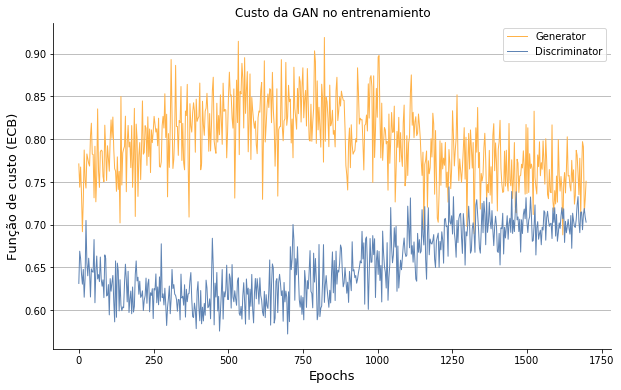

In [79]:
fig = plt.figure(figsize=(10,6))
ax1 = fig.add_subplot()
ax1.spines["top"].set_visible(False)
ax1.spines["right"].set_visible(False)
rr = range(0,len(d_precision), 3)
short_g_loss = [g_loss[i] for i in rr]
short_d_loss = [d_loss[i] for i in rr]
#plt.title("Loss da GAN nas épocas do treinamento", fontsize=15)
plt.title("Custo da GAN no entrenamiento")
plt.plot(rr, short_g_loss, label="Generator", color="#FFB248", linewidth=1)
plt.plot(rr, short_d_loss, label="Discriminator", color="#5F84B4", linewidth=1)
plt.xlabel("Epochs", fontsize=13)
plt.ylabel("Função de custo (ECB)", fontsize=13)
plt.grid(axis="y")
plt.legend();

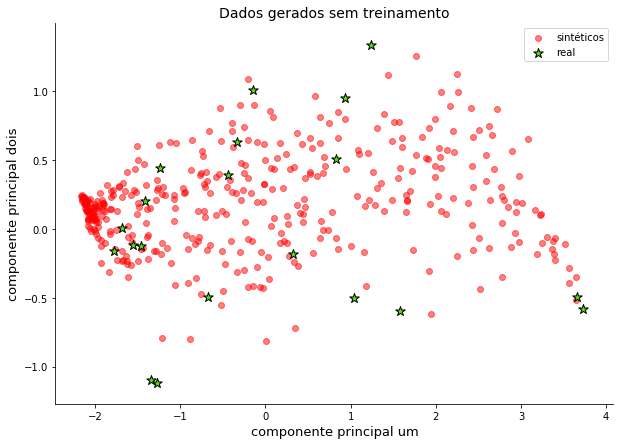

In [46]:
pca_real = PCA(n_components=2)
X_train_pca = pca_real.fit_transform(X_train)

noise = np.random.normal(0, 1, size=(X_train.shape[0]*20, noise_input))
fig1 = plt.figure(figsize=(10,7))
ax1 = fig1.add_subplot()
ax1.spines["top"].set_visible(False)
ax1.spines["right"].set_visible(False)
plt.title("Dados gerados sem treinamento", fontsize=14)
plt.xlabel("componente principal um", fontsize=13)
plt.ylabel("componente principal dois", fontsize=13)
x_noise = G.predict(noise)
X_sint_pca = pca_real.transform(x_noise)
plt.scatter(X_sint_pca[:,0], X_sint_pca[:,1], color="red", label="sintéticos", alpha=.5)
plt.scatter(X_train_pca[:,0], X_train_pca[:,1], color="#5ADE09", label="real", alpha=1,
            marker="*", edgecolors="black", s=100)
plt.legend();